In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import sawtooth

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

the number of data points: 160000


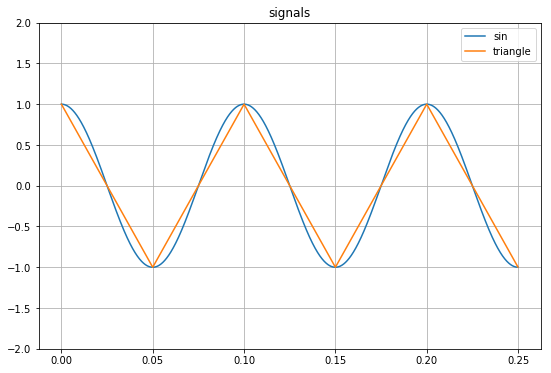

In [4]:
# 学習に使う人工データの生成
sampling_rate = 16000  # サンプリング周波数 [Hz]
len_seconds = 10  # データの波形の秒数 [s]
f_original = 10  # データの波形の周波数
t = np.arange(0, len_seconds, 1 / sampling_rate)  # サンプリング点
x_signal = np.cos(2 * np.pi * f_original * t)  # 正弦波の生成
y_signal = np.array(sawtooth(2 * np.pi * f_original * t + np.pi, 0.5))  # 三角波の生成
print('the number of data points:', len(x_signal))

# 原信号を描画する
%matplotlib inline
plt.figure(figsize = (9, 6))
plt.plot(t[:4000], x_signal[:4000], label='sin')
plt.plot(t[:4000], y_signal[:4000], label='triangle')
plt.title('signals')
plt.ylim([-2.0, 2.0])
plt.grid()
plt.legend()
plt.show()

In [5]:
class UnpairedWaveDataset(Dataset):
    def __init__(self, x, y, length, sync, transform=None):
        self.x = x
        self.y = y
        self.length = length
        self.sync = sync
        self.transform = transform
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        begin_x = np.random.randint(len(self.x) - self.length)
        if self.sync:
            begin_y = begin_x
        else:
            begin_y = np.random.randint(len(self.y) - self.length)
        x_sample = self.x[begin_x:begin_x+self.length]
        y_sample = self.y[begin_y:begin_y+self.length]
        
        if self.transform is not None:
            x_sample = self.transform(x_sample)
            y_sample = self.transform(y_sample)
        return x_sample, y_sample

In [8]:
SAMPLE_LENGTH = 256
BATCH_SIZE = 1
dataset = UnpairedWaveDataset(x_signal, y_signal, SAMPLE_LENGTH, True, torch.from_numpy)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
class ResNetBlock(nn.Module):
    def __init__(self, channel, dilation):
        super(ResNetBlock, self).__init__()
        self.conv_block = nn.Sequential(
                            nn.Conv1d(channel, channel, kernel_size=3, stride=1, padding=dilation, dilation=dilation),
                            nn.InstanceNorm1d(channel),
                            nn.ReLU(inplace=True),
                            nn.Conv1d(channel, channel, kernel_size=3, stride=1, padding=dilation, dilation=dilation),
                            nn.InstanceNorm1d(channel),
                            nn.ReLU(inplace=True)
                          )
        
    def forward(self, x):
        out = x + self.conv_block(x)
        return out

In [16]:
class Generator(nn.Module):
    def __init__(self, channels, dilations):
        super(Generator, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Conv1d(1, channels[0], kernel_size=1, stride=1, padding=0))
        self.layers.append(nn.ReLU(inplace=True))
        for c, d in zip(channels, dilations):
            self.layers.append(ResNetBlock(c, d))
        self.layers.append(nn.Conv1d(channels[-1], 1, kernel_size=1, stride=1, padding=0))
        self.layers.append(nn.Tanh())
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.layers = nn.Sequential(
                        nn.Conv1d(1, 32, kernel_size=4, stride=2, padding=1),
                        nn.LeakyReLU(0.2, inplace=True),
                        
                        nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1),
                        nn.InstanceNorm1d(64),
                        nn.LeakyReLU(0.2, inplace=True),
                        
                        nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
                        nn.InstanceNorm1d(128),
                        nn.LeakyReLU(0.2, inplace=True),
                        
                        nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
                        nn.InstanceNorm1d(256),
                        nn.LeakyReLU(0.2, inplace=True),
            
                        nn.Conv1d(256, 1, kernel_size=3, stride=1, padding=1),
        )
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

gen_X2Y = Generator([64]*6, [1, 1, 2, 2, 4, 4]).to(device)
gen_Y2X = Generator([64]*6, [1, 1, 2, 2, 4, 4]).to(device)
dis_X = Discriminator().to(device)
dis_Y = Discriminator().to(device)

optim_gen_X2Y = optim.Adam(gen_X2Y.parameters(), lr=0.0002, betas=[0.5, 0.999])
optim_gen_Y2X = optim.Adam(gen_Y2X.parameters(), lr=0.0002, betas=[0.5, 0.999])
optim_dis_X = optim.Adam(dis_X.parameters(), lr=0.0002, betas=[0.5, 0.999])
optim_dis_Y = optim.Adam(dis_Y.parameters(), lr=0.0002, betas=[0.5, 0.999])

lambda_cyc = 1.0
lambda_idt = 1.0

In [19]:
def train(data_loader):
    gen_X2Y.train()
    gen_Y2X.train()
    dis_X.train()
    dis_Y.train()
    
    loss_overall = 0
    losses_overall = np.zeros(3)  # adversarial, cycle consistency, identity
    losses_adv = np.zeros(2)  # loss_adv_gen, loss_adv_dis
    
    
    for real_X, real_Y in data_loader:
        real_X = real_X.to(device)
        real_Y = real_Y.to(device)
        
        # adversarial loss for X -> Y
        fake_Y = gen_X2Y(real_X)
        pred_fake_Y = dis_Y(fake_Y)
        loss_adv_gen_X2Y = F.binary_cross_entropy_with_logits(pred_fake_Y, torch.ones_like(pred_fake_Y))
        
        pred_real_Y = dis_Y(real_Y)
        loss_adv_dis_Y = F.binary_cross_entropy_with_logits(pred_real_Y, torch.ones_like(pred_real_Y))
        pred_fake_Y = dis_Y(fake_Y.detach())
        loss_adv_dis_Y += F.binary_cross_entropy_with_logits(pred_fake_Y, torch.zeros_like(pred_fake_Y))
        
        # adversarial loss for Y -> X
        fake_X = gen_Y2X(real_Y)
        pred_fake_X = dis_X(fake_X)
        loss_adv_gen_Y2X = F.binary_cross_entropy_with_logits(pred_fake_X, torch.ones_like(pred_fake_X))
        
        pred_real_X = dis_X(real_X)
        loss_adv_dis_X = F.binary_cross_entropy_with_logits(pred_real_X, torch.ones_like(pred_real_X))
        pred_fake_X = dis_X(fake_X.detach())
        loss_adv_dis_X += F.binary_cross_entropy_with_logits(pred_fake_X, torch.zeros_like(pred_fake_X))
        
        loss_adv_gen = loss_adv_gen_X2Y + loss_adv_gen_Y2X
        loss_adv_dis = loss_adv_dis_X + loss_adv_dis_Y
                
        # cycle consistency loss for X
        recon_X = gen_Y2X(fake_Y)
        loss_cyc_X = F.l1_loss(recon_X, real_X)
        
        # cycle consistency loss for Y
        recon_Y = gen_X2Y(fake_X)
        loss_cyc_Y = F.l1_loss(recon_Y, real_Y)
        
        loss_cyc = loss_cyc_X + loss_cyc_Y
        
        # identity mapping loss for X
        pass_X = gen_X2Y(real_X)
        loss_idt_X = F.l1_loss(pass_X, real_X)
        
        # identity mapping loss for Y
        pass_Y = gen_Y2X(real_Y)
        loss_idt_Y = F.l1_loss(pass_Y, real_Y)
        
        loss_idt = loss_idt_X + loss_idt_Y
        
        loss_gen = loss_adv_gen + lambda_cyc*loss_cyc + lambda_idt*loss_idt
        loss_dis = loss_adv_dis
        
        optim_dis_X.zero_grad()
        optim_dis_Y.zero_grad()
        loss_dis.backward()
        optim_dis_X.step()
        optim_dis_Y.step()
        
        optim_gen_X2Y.zero_grad()
        optim_gen_Y2X.zero_grad()
        loss_gen.backward()
        optim_gen_X2Y.step()
        optim_gen_Y2X.step()

        loss_overall += loss_gen.item() + loss_dis.item()
        losses_overall[0] += loss_adv_gen.item() + loss_adv_dis.item()
        losses_overall[1] += loss_cyc.item()
        losses_overall[2] += loss_idt.item()
        losses_adv[0] += loss_adv_gen.item()
        losses_adv[1] += loss_adv_dis.item()
    
    loss_overall /= len(data_loader)
    losses_overall /= len(data_loader)
    losses_adv /= len(data_loader)
    
    return loss_overall, losses_overall, losses_adv

In [ ]:
n_epochs = 20
train_loss_list = [[],[]]
val_loss_list = [[],[]]

for epoch in range(n_epochs):
    train_gen_loss, train_dis_loss = train(train_loader)
    val_gen_loss, val_dis_loss = val(val_loader, epoch)
    
    train_loss_list[0].append(train_gen_loss)
    train_loss_list[1].append(train_dis_loss)
    val_loss_list[0].append(val_gen_loss)
    val_loss_list[1].append(val_dis_loss)
    
    if epoch % 2 == 0:
        torch.save(generator.state_dict(), save_dir + 'generator_' + str(epoch) + '.pth')
        torch.save(discriminator.state_dict(), save_dir + 'discriminator_' + str(epoch) + '.pth')
        torch.save(gen_optimizer.state_dict(), save_dir + 'gen_optmizer_' + str(epoch) + '.pth')
        torch.save(dis_optimizer.state_dict(), save_dir + 'gen_discriminator' + str(epoch) + '.pth')
    
    print('epoch[%d/%d] losses[train_gen:%1.4f train_dis:%1.4f  val_gen:%1.4f val_dis:%1.4f]'                     % (epoch+1, n_epochs, train_gen_loss, train_dis_loss, val_gen_loss, val_dis_loss))
    
np.save(save_dir +  'train_loss_list.npy', np.array(train_loss_list))
np.save(save_dir + 'validation_loss_list.npy', np.array(val_loss_list))